In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

In [2]:
# Get the data
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

# loop over train_data tuple of type tf.tensor and convert to list with .numpy()
for text,label in train_data:
  training_sentences.append(str(text.numpy()))
  training_labels.append(label.numpy())
  
for text,label in test_data:
  testing_sentences.append(str(text.numpy()))
  testing_labels.append(label.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


2022-03-12 10:02:56.496286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 10:02:56.575723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


In [25]:
# vocab_size = 10000
embedding_dim = 100
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [26]:
# Using Stanford's GloVe embedding

embeddings_index = {};
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [30]:
#-----------------------------------------------------------
# basic NN with dense layers
# training accuracy = 1 (after 10 epochs)
# validation accuracy = 0.83 (after 10 epochs) decreasing with epochs
# validation loss increasing with epochs --> overfitting
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

#-----------------------------------------------------------
# multi-layer LSTM 
# training accuracy = 1 (after 10 epochs)
# validation accuracy = 0.82 (after 10 epochs) slight decrease with epochs
# validation loss increasing with epochs --> overfitting
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

#-----------------------------------------------------------
# single-layer LSTM with dropout layer and custom optimizer according to original dropout paper
# N. Srivastava, J. Mach. Learn. Res. 15 (2014) 1929-1958
# training accuracy = 0.94 (after 10 epochs)
# validation accuracy = 0.83 (after 10 epochs)
# validation loss decreasing with epochs (up to 5 epochs) --> NOT overfitting
# validation loss increases after 5 epochs, suggesting early stoppage at 5 to avoid overfitting beyond this
#-----------------------------------------------------------

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# -----------------------------------------------------------
# single-layer LSTM, convolution 1D layer, with dropout layers and custom optimizer 
# -----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

#-----------------------------------------------------------
# multi-layer LSTM, with dropout layers and custom optimizer 
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [31]:
sgd=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9) #custom optimizer
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [32]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 32s 39ms/step - loss: 0.6070 - accuracy: 0.6532 - val_loss: 0.4712 - val_accuracy: 0.7850
Epoch 2/10
782/782 [==============================] - 30s 38ms/step - loss: 0.4832 - accuracy: 0.7709 - val_loss: 0.4846 - val_accuracy: 0.7670
Epoch 3/10
782/782 [==============================] - 30s 39ms/step - loss: 0.4545 - accuracy: 0.7870 - val_loss: 0.4408 - val_accuracy: 0.7930
Epoch 4/10
782/782 [==============================] - 30s 38ms/step - loss: 0.4394 - accuracy: 0.7960 - val_loss: 0.3959 - val_accuracy: 0.8258
Epoch 5/10
782/782 [==============================] - 33s 42ms/step - loss: 0.4311 - accuracy: 0.8009 - val_loss: 0.3987 - val_accuracy: 0.8221
Epoch 6/10
782/782 [==============================] - 32s 41ms/step - loss: 0.4211 - accuracy: 0.8082 - val_loss: 0.3838 - val_accuracy: 0.8327
Epoch 7/10
782/782 [==============================] - 31s 40ms/step - loss: 0.4072 - accuracy: 0.8132 - val_loss: 0.3967 - val_accuracy:

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('Single LSTM w/ dropout & GloVe')
  plt.show()

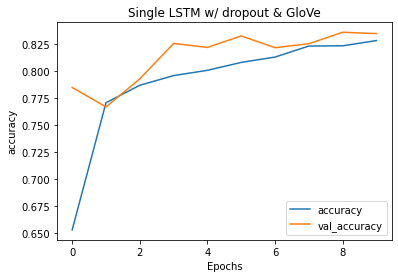

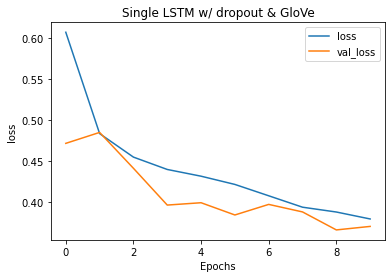

In [37]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

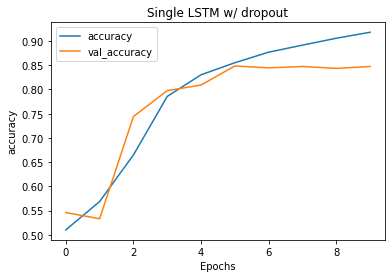

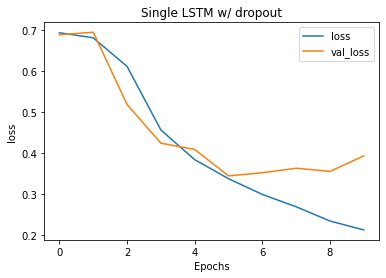

In [10]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

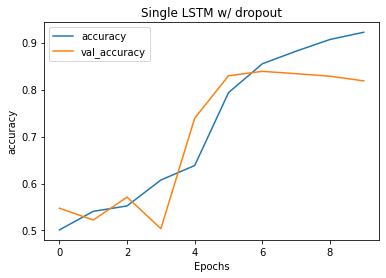

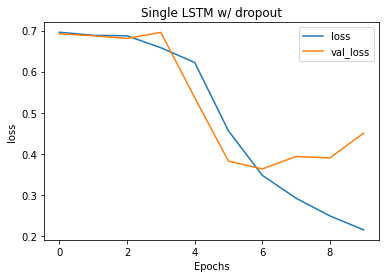

In [17]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

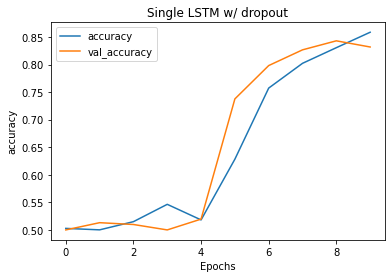

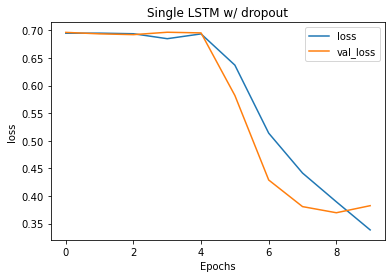

In [9]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

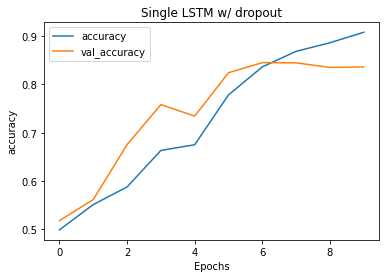

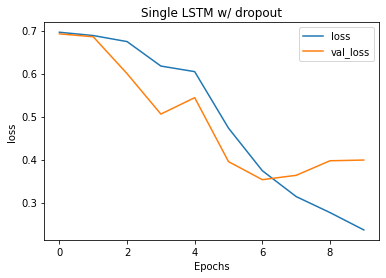

In [13]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')